In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import numpy as np

cores = 4

In [191]:
tweets_with_originals = pd.read_csv('tweets_with_originals.csv', parse_dates = ['tweet_created'])

In [151]:
tweets_with_originals['text_clean'] = tweets_with_originals.text_clean.str.replace(r'@(\w+)([\s.,:;!])?', r'\1 ') # remove @s in @mentions

In [152]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string
#stopwords = stopwords.union(set([i for i in string.punctuation])) # remove punctuation
#stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))

In [153]:
tweets_with_originals.loc[55].text_clean

"VirginAmerica hi! i'm so excited about your $99 LGA->DAL deal- but i've been trying 2 book since last week & the page never loads. thx!"

# TF-IDF to identify additional stopwords 

Using TF-IDF, we'll look for additional stopwords 

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10)
tweet_input = tweets_with_originals.text_clean
# maybe try to take out numbers, prices 
tweet_input=tweet_input.str.replace(r" (\d|\W)+","") # remove digits, nonword things
T = tfidf_vectorizer.fit_transform(tweet_input) # these are our features

In [155]:
idf_df = pd.DataFrame(index = tfidf_vectorizer.get_feature_names())
idf_df['idf_vals']= tfidf_vectorizer.idf_
idf_df.describe()

,idf_vals
count,1628.000000
mean,7.120723
std,0.958025
min,2.421465
25%,6.609403
50%,7.360819
75%,7.871644
max,8.181799


The minimum inverse document frequency is not so low. For our first pass I won't add any stopwords based on IDF values. 

We can use this array of tfidf vectors as input features... for testing purposes we'll also allow 2-grams and 3-grams to see if this improves the result. 

In [156]:
tf2_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,2))
tf3_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,3))
T_2 = tf2_vectorizer.fit_transform(tweet_input) 
T_3 = tf3_vectorizer.fit_transform(tweet_input)

tfidf_input_mats = [T, T_2, T_3]

# Word2Vec Model 

First we'll train a word2vec model on our tweets and see what sorts of words are grouped together. 

In [169]:
from nltk.tokenize.casual import TweetTokenizer
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
cores = 4 # depends on how many cores you have...

tokenizer = TweetTokenizer(preserve_case=False)
tokenized_input = [tokenizer.tokenize(tweet) for tweet in tweet_input.values]
tokenized_input = [[word for word in tweet if word not in string.punctuation] for tweet in tokenized_input]
model = Word2Vec(tokenized_input, window=5, min_count=10, workers=cores) # build vocabulary

model.train(tokenized_input, total_examples=len(tokenized_input), epochs=10)
model.save('airlinetweet_word2vec.model')

The results look ok, airlines are associated with other airlines...

In [170]:
model.wv.most_similar('united')

[('jetblue', 0.8487025499343872),
 ('americanair', 0.8106632828712463),
 ('southwestair', 0.8071470260620117),
 ('usairways', 0.7406232357025146),
 ('virginamerica', 0.6764417290687561),
 ('guess', 0.5161033868789673),
 ('that', 0.4979885220527649),
 ('but', 0.4899892210960388),
 ('report', 0.4859675168991089),
 ('wondering', 0.485517680644989)]

In [171]:
model.wv.most_similar('usairways')

[('americanair', 0.8520444631576538),
 ('southwestair', 0.755211353302002),
 ('united', 0.7406232357025146),
 ('jetblue', 0.6881105303764343),
 ('virginamerica', 0.4875844120979309),
 ('mind', 0.4604579210281372),
 ('answer', 0.4387776851654053),
 ('idea', 0.437568724155426),
 ('guess', 0.43490761518478394),
 ('god', 0.4206146001815796)]

And TSA with security check type things

In [172]:
model.wv.most_similar('tsa')

[('pre', 0.8376373648643494),
 ('file', 0.8244051933288574),
 ('id', 0.7594149112701416),
 ('res', 0.7305185198783875),
 ('receipt', 0.7169848680496216),
 ('request', 0.7129449844360352),
 ('confirm', 0.7089828252792358),
 ('didnt', 0.6984065771102905),
 ('name', 0.6952228546142578),
 ('message', 0.6845541596412659)]

## Doc2Vec Model

Doc2Vec learns "document" vectors instead of word vectors. We view each tweet as a document

In [173]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
sentiment_tweets_docs = [TaggedDocument(tokenized_input[i], [str(tweets_with_originals.tweet_id.iloc[i])]) for i in range(tweet_input.shape[0])]

In [221]:
model_doc2vec = Doc2Vec(dm=1, vector_size=200, hs=1, 
                        min_count=10, sample=0, epochs=20, alpha = .25, 
                        workers=cores, dbow_words = 1)
model_doc2vec.build_vocab(sentiment_tweets_docs)
model_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_doc2vec.save('airlinetweet_doc2vec.model')

In [222]:
model_doc2vec.wv.most_similar('late')

[('waited', 0.6950336694717407),
 ('la', 0.608649492263794),
 ('thepm', 0.5627830624580383),
 ('sadly', 0.5473147630691528),
 ('since', 0.5428346395492554),
 ('reschedule', 0.5424113273620605),
 ('extremely', 0.54144287109375),
 ('unavailable', 0.5358824729919434),
 ('prompt', 0.5322866439819336),
 ('disconnected', 0.5311041474342346)]

In [223]:
model_doc2vec.wv.most_similar('delay')

[('three', 0.655289888381958),
 ('bad', 0.620830237865448),
 ('always', 0.5640743374824524),
 ('offering', 0.555300235748291),
 ('ind', 0.5538690090179443),
 ('errors', 0.5382016897201538),
 ('back', 0.531449556350708),
 ('crews', 0.5203275084495544),
 ('doors', 0.5180415511131287),
 ('look', 0.5165101289749146)]

In [224]:
model_doc2vec.wv.most_similar('tsa')

[('hold', 0.8266901969909668),
 ('spend', 0.7805395126342773),
 ('decision', 0.7694655656814575),
 ('status', 0.7614593505859375),
 ('down', 0.7608448266983032),
 ('contacted', 0.760501503944397),
 ('ago', 0.7530394792556763),
 ('stuff', 0.742179274559021),
 ('once', 0.7391839027404785),
 ('march', 0.7355906963348389)]

In [225]:
model_doc2vec.docvecs.most_similar('570085644015419393')

[('569531924219191296', 0.8118668794631958),
 ('569618014141751298', 0.7929052114486694),
 ('568974423358726144', 0.7644776105880737),
 ('568706272788262912', 0.7643887400627136),
 ('568380749495164929', 0.7576995491981506),
 ('570035525761011713', 0.75504070520401),
 ('567778921812389888', 0.7548619508743286),
 ('568620542682468352', 0.7498431205749512),
 ('569604083507556353', 0.744074821472168),
 ('569671712830308352', 0.7395763993263245)]

The following tweets are quite similar according to the model: 

In [214]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570085644015419393]['text_clean'].values

array(["USAirways  A few years ago I lost over 50,00 miles bc I was physically unable to fly during the period.  I submitted a doctor's note."],
      dtype=object)

In [226]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 569531924219191296]['text_clean'].values

array(["JetBlue it's been 3 hours, why have you not sent the plane from the hangar for flight 1533 at JFK? This is absolutely ridiculous."],
      dtype=object)

In [227]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 568974423358726144]['text_clean'].values

array(['SouthwestAir flight to San Diego is delayed per usual. take me home!'],
      dtype=object)

They are at least all negative sentiment tweets, so hopefully we're heading in the right direction. 

In [187]:
tweets_with_originals.tweet_id.sample()

9621    569810990189191168
Name: tweet_id, dtype: int64

**TODO**: 

model tuning, doc2vec. Experiment more with hierarchical softmax versus negative sampling for model training. alpha tuning also needed. 

# Sentiment Analysis

The sentiments in our dataset are highly imbalanced: 

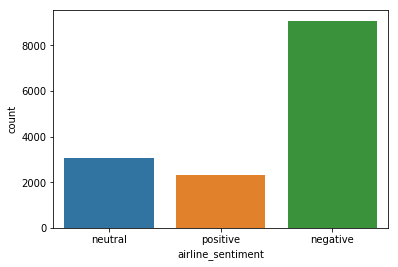

In [15]:
_ = sns.countplot(x = 'airline_sentiment', data = tweets_with_originals)

There are a lot of strategies we could try to rebalance the dataset. The easiest would be oversampling the neutral/positive sentiment tweets. 

In [16]:
# test split with oversampling ... try SMOTE 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
y = tweets_with_originals.airline_sentiment.map({'negative': 0, 'neutral':1, 'positive':2})

# test_train split for TFIDF outputs 

train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())

# test_train_split for 

NameError: name 'X' is not defined

## Method 1: TF-IDF output